In [82]:
import gcp.storage as storage
import gcp.bigquery as bq

# Orders

In [2]:
%%sql
SELECT COUNT(*) FROM [datalab-projects-1331:xjk_algo_comp_test.orders]

f0_
1110625


Let's see what dates have orders in the test dataset

In [13]:
%%sql --module orders_by_date
SELECT date, COUNT(*) AS num_orders FROM [datalab-projects-1331:xjk_algo_comp_test.orders]
GROUP BY date
ORDER BY date

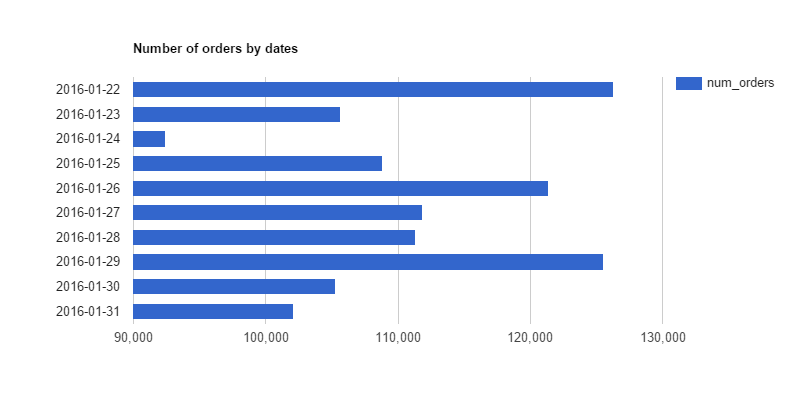

In [14]:
%%chart bars --data orders_by_date
title: Number of orders by dates
height: 400

Looks like data from date 22 to 31 are available. Date 24 and 31 seems to contain less orders, is this the same with training data? We will look into this again later when exploring training data. Looks like they are the same day in week: Sunday.

In [47]:
%%sql
SELECT date, COUNT(*) AS num_orders, FIRST(day_in_week) AS day_in_week
FROM [datalab-projects-1331:xjk_algo_comp_test.orders]
GROUP BY date
ORDER BY date

date,num_orders,day_in_week
2016-01-22,126309,5
2016-01-23,105634,6
2016-01-24,92437,0
2016-01-25,108791,1
2016-01-26,121362,2
2016-01-27,111815,3
2016-01-28,111343,4
2016-01-29,125552,5
2016-01-30,105278,6
2016-01-31,102104,0


And now, let's compare with timeslots in requested predictions to find a pattern:

In [63]:
item = storage.Item('datalab-projects-1331-datalab','data/timeslots_to_test2.txt')
slots = map(lambda x: x.strip(), item.read_from().strip().split('\n'))
print(slots)

['2016-01-23-46', '2016-01-23-58', '2016-01-23-70', '2016-01-23-82', '2016-01-23-94', '2016-01-23-106', '2016-01-23-118', '2016-01-23-130', '2016-01-23-142', '2016-01-25-58', '2016-01-25-70', '2016-01-25-82', '2016-01-25-94', '2016-01-25-106', '2016-01-25-118', '2016-01-25-130', '2016-01-25-142', '2016-01-27-46', '2016-01-27-58', '2016-01-27-70', '2016-01-27-82', '2016-01-27-94', '2016-01-27-106', '2016-01-27-118', '2016-01-27-130', '2016-01-27-142', '2016-01-29-58', '2016-01-29-70', '2016-01-29-82', '2016-01-29-94', '2016-01-29-106', '2016-01-29-118', '2016-01-29-130', '2016-01-29-142', '2016-01-31-46', '2016-01-31-58', '2016-01-31-70', '2016-01-31-82', '2016-01-31-94', '2016-01-31-106', '2016-01-31-118', '2016-01-31-130', '2016-01-31-142']


Test dataset contains all the dates used in requested predictions.

How about the timeslots? Let's plot number of orders of all timeslots in date 2016-01-22.

In [10]:
%%sql --module orders_by_timeslot
SELECT FIRST(timeslot), COUNT(*) AS num_orders FROM [datalab-projects-1331:xjk_algo_comp_test.orders]
WHERE date IN ('2016-01-22')
GROUP BY date, timeofday_slot
ORDER BY date, timeofday_slot

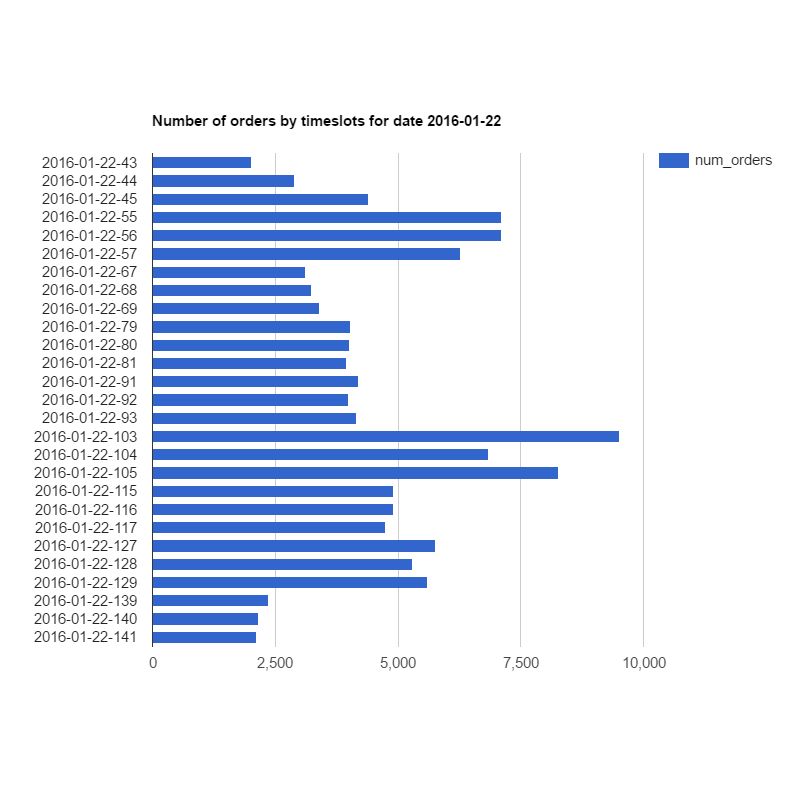

In [11]:
%%chart bars --data orders_by_timeslot
title: Number of orders by timeslots for date 2016-01-22
height: 800

Interesting. Looks like data from three timeslots prior to each timeslot to predict are available (for example, orders from 2016-01-22-43, 2016-01-22-44, 2016-01-22-45 are used to predict gaps in 2016-01-22-46).

At this point, we know that the workable dataset should contain information from last three timeslots' orders. The exact features to include will be revealed further on next section's exploration, but what is clear at this point is that at least `gap_1_slots_ago`, `gap_2_slots_ago`, and `gap_3_slots_ago` should be part of the features (apology for the grammar of these features, `slot` was named `slots` for `1_slot` for easier programming).

How about other tables?

# POIs

In [93]:
%%sql
SELECT COUNT(*) FROM [datalab-projects-1331:xjk_algo_comp_test.pois]

f0_
66


Number of rows: 66 (proves that all districts have pois)

As mentioned in "Datasets" section above, **pois** table (I assume POI is an abbreviation of Place Of Interest) contains all of the facilities and sub facilities of each district. I wrangled this table so that pois are stored as fields instead of tab separated data point i.e. from
value "1#11:10\\t1#12:20" to `f1_11` and `f1_12` fields with values 10 and 20 respectively.

Let's see how many facilities ('POIs') and main facilities ('main POIs') there are. This one is from the test dataset:

In [91]:
pois_table = bq.Table('datalab-projects-1331:xjk_algo_comp_test.pois')
pois_fields = [item['name'] for item in pois_table.schema][1:]
print "All test dataset POIs:"
print pois_fields
print "total: {}".format(len(pois_fields))
len(pois_fields)
print "Main POIs:"
main_pois = list(set(map(lambda x: x.split('_')[0], pois_fields)))
print main_pois
print "total: {}".format(len(main_pois))

All test dataset POIs:
[u'f1', u'f11', u'f11_1', u'f11_2', u'f11_3', u'f11_4', u'f11_5', u'f11_6', u'f11_7', u'f11_8', u'f13_4', u'f13_8', u'f14', u'f14_1', u'f14_10', u'f14_2', u'f14_3', u'f14_6', u'f14_8', u'f15', u'f15_1', u'f15_2', u'f15_3', u'f15_4', u'f15_6', u'f15_7', u'f15_8', u'f16', u'f16_1', u'f16_10', u'f16_11', u'f16_12', u'f16_3', u'f16_4', u'f16_6', u'f17', u'f17_2', u'f17_3', u'f17_4', u'f17_5', u'f19', u'f19_1', u'f19_2', u'f19_3', u'f19_4', u'f1_1', u'f1_10', u'f1_11', u'f1_2', u'f1_3', u'f1_4', u'f1_5', u'f1_6', u'f1_7', u'f1_8', u'f20', u'f20_1', u'f20_2', u'f20_4', u'f20_5', u'f20_6', u'f20_7', u'f20_8', u'f20_9', u'f21_1', u'f21_2', u'f22', u'f22_1', u'f22_2', u'f22_3', u'f22_4', u'f22_5', u'f23', u'f23_1', u'f23_2', u'f23_3', u'f23_4', u'f23_5', u'f23_6', u'f24', u'f24_1', u'f24_2', u'f24_3', u'f25', u'f25_1', u'f25_3', u'f25_7', u'f25_8', u'f25_9', u'f2_1', u'f2_10', u'f2_11', u'f2_12', u'f2_13', u'f2_2', u'f2_4', u'f2_5', u'f2_6', u'f2_7', u'f2_8', u'f3_1', u'f

There is a possibility that there are different number of POIs used in training and testing data, in which treatment of this POI data should be different, but from the following output seems like both of them have similar POIs (which is understandable since both training and testing data have the same districts).

In [92]:
pois_table = bq.Table('datalab-projects-1331:xjk_algo_comp.pois')
pois_fields = [item['name'] for item in pois_table.schema][1:]
print "All training dataset POIs:"
print pois_fields
print "total: {}".format(len(pois_fields))
len(pois_fields)
print "Main POIs:"
main_pois = list(set(map(lambda x: x.split('_')[0], pois_fields)))
print main_pois
print "total: {}".format(len(main_pois))

All training dataset POIs:
[u'f1', u'f11', u'f11_1', u'f11_2', u'f11_3', u'f11_4', u'f11_5', u'f11_6', u'f11_7', u'f11_8', u'f13_4', u'f13_8', u'f14', u'f14_1', u'f14_10', u'f14_2', u'f14_3', u'f14_6', u'f14_8', u'f15', u'f15_1', u'f15_2', u'f15_3', u'f15_4', u'f15_6', u'f15_7', u'f15_8', u'f16', u'f16_1', u'f16_10', u'f16_11', u'f16_12', u'f16_3', u'f16_4', u'f16_6', u'f17', u'f17_2', u'f17_3', u'f17_4', u'f17_5', u'f19', u'f19_1', u'f19_2', u'f19_3', u'f19_4', u'f1_1', u'f1_10', u'f1_11', u'f1_2', u'f1_3', u'f1_4', u'f1_5', u'f1_6', u'f1_7', u'f1_8', u'f20', u'f20_1', u'f20_2', u'f20_4', u'f20_5', u'f20_6', u'f20_7', u'f20_8', u'f20_9', u'f21_1', u'f21_2', u'f22', u'f22_1', u'f22_2', u'f22_3', u'f22_4', u'f22_5', u'f23', u'f23_1', u'f23_2', u'f23_3', u'f23_4', u'f23_5', u'f23_6', u'f24', u'f24_1', u'f24_2', u'f24_3', u'f25', u'f25_1', u'f25_3', u'f25_7', u'f25_8', u'f25_9', u'f2_1', u'f2_10', u'f2_11', u'f2_12', u'f2_13', u'f2_2', u'f2_4', u'f2_5', u'f2_6', u'f2_7', u'f2_8', u'f3_1',

At this point, we are sure that we can include all these features into **gaps** dataset.

# Traffic

In [94]:
%%sql
SELECT COUNT(*) FROM [datalab-projects-1331:xjk_algo_comp.traffic]

f0_
193553


Number of rows: 193,553

Traffic information seems important. Perhaps drivers will be less likely to accept requests when traffic was more jammed? Or even the other way around? We will explore the correlation in the next step, at this point we just want to make sure if we can indeed enter traffic information into our **gaps** gaps dataset.

Let's see what data are available from **traffic** dataset. As previously with orders, I have added `timeslot` into 

In [8]:
%%sql --module traffic_by_date
SELECT date, COUNT(*) AS num_traffic FROM [datalab-projects-1331:xjk_algo_comp_test.traffic]
GROUP BY date
ORDER BY date

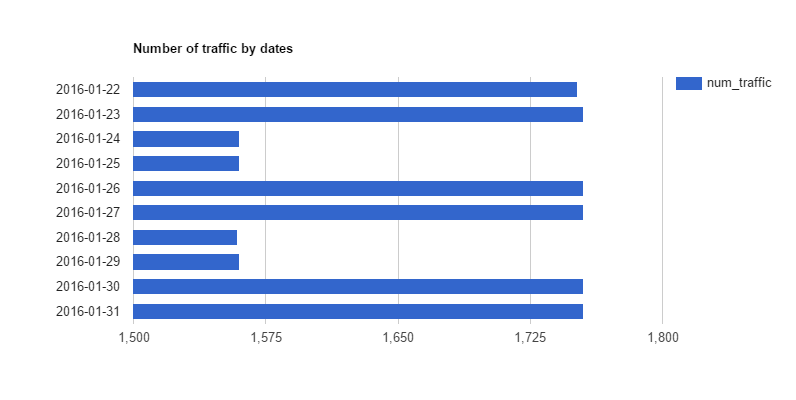

In [15]:
%%chart bars --data traffic_by_date
title: Number of traffic by dates
height: 400

Similar with above, we have 10 days of the same dates.

In [3]:
%%sql --module traffic_by_timeslot
SELECT FIRST(timeslot), COUNT(*) AS num_traffic FROM [datalab-projects-1331:xjk_algo_comp_test.traffic]
WHERE date IN ('2016-01-22')
GROUP BY date, timeofday_slot
ORDER BY date, timeofday_slot

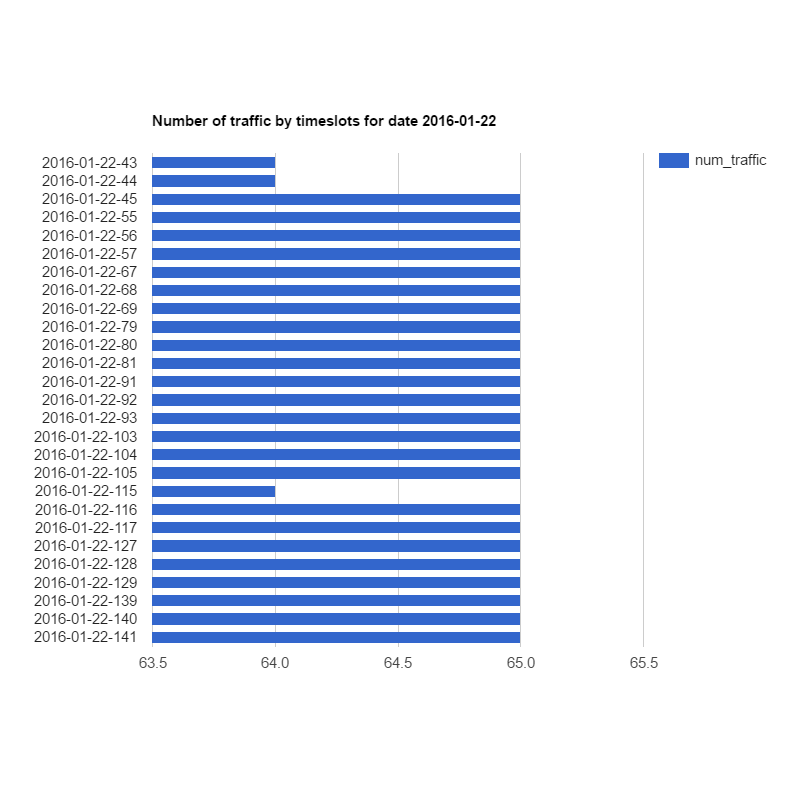

In [6]:
%%chart bars --data traffic_by_timeslot
title: Number of traffic by timeslots for date 2016-01-22
height: 800

Some data seems to be missing at some timeslots